# T-Maze Interactive Simulation

This notebook executes the action-perception loop for a discrete SSM.

In [170]:
using Pkg
Pkg.activate("../..")
# Pkg.instantiate()

  Activating project at `c:\Simulations\EpistemicMessagePassing`


In [171]:
using LinearAlgebra
using ForneyLab
using Plots
using ForwardDiff: hessian
# using ProgressMeter

# T-maze layout
# [2| |3]
#   | |
#   |1|
#   |4|

include("factor_nodes/discrete_observation.jl")
include("update_rules/discrete_observation.jl")
;

# Generative Model

In [172]:
fg = FactorGraph()

u = Vector{Variable}(undef, 2)
x = Vector{Variable}(undef, 2)
y = Vector{Variable}(undef, 2)

@RV x_0 ~ Categorical(placeholder(:D_s, dims=(8,)))
@RV A ~ Dirichlet(placeholder(:A_s, dims=(16,8)))

x_k_min = x_0
for k=1:2
    @RV u[k]
    @RV x[k] ~ Transition(x_k_min, u[k])
    placeholder(u[k], :u, index=k, dims=(8,8))
    @RV y[k] ~ DiscreteObservation{Generalized}(x[k], A,
                   placeholder(:C, dims=(16,), var_id=:C_*k),
                   n_factors=8)
    
    x_k_min = x[k] # For next slice
end
;

# Algorithm

In [173]:
q = PosteriorFactorization(y, [x_0; x], A, ids=[:Y, :X, :A])
# q = PosteriorFactorization(y, x_0, x; ids=[:Y, :X0, :X])
algo = messagePassingAlgorithm(q, free_energy=true)
code = algorithmSourceCode(algo, free_energy=true)
initX() = Array{Message}(undef, 9) # Predefine
eval(Meta.parse(code)) # Overwrites initX for Generalized constraint
;

In [174]:
# println(code)

## Action-Perception Loop

In [175]:
α = 0.9; c = 2.0 # Reward probability and utility
n_its = 50
G = Vector{Float64}(undef, n_its)

include("helpers.jl")
include("environment.jl")
include("agent.jl")

(A, B, C, D) = constructABCD(α, c)
(A_0, D_0) = constructPriors() # Construct prior statistics for A and D
A_0 = 10.0*A .+ 0.01

pol = (4,2)

data = Dict(:u   => [B[pol[1]], B[pol[2]]],
            :A_s => A_0,
            :C   => C,
            :D_s => D_0)

marginals = Dict{Symbol, ProbabilityDistribution}(
    :x_0 => ProbabilityDistribution(Univariate, Categorical, p=asym(8)),
    :x_1 => ProbabilityDistribution(Univariate, Categorical, p=asym(8)),
    :x_2 => ProbabilityDistribution(Univariate, Categorical, p=asym(8)),
    :A => ProbabilityDistribution(MatrixVariate, Dirichlet, a=asym(A_0)))

# Define unobserved marginals
marginals[:y_1] = Distribution(Univariate, Categorical, p=asym(16))
marginals[:y_2] = Distribution(Univariate, Categorical, p=asym(16))

messages = initX()
            
for i=1:n_its
    # stepX0!(data, marginals)
    stepX!(data, marginals, messages)
    stepA!(data, marginals)
    stepY!(data, marginals)
    G[i] = freeEnergy(data, marginals)/log(2)
end
;

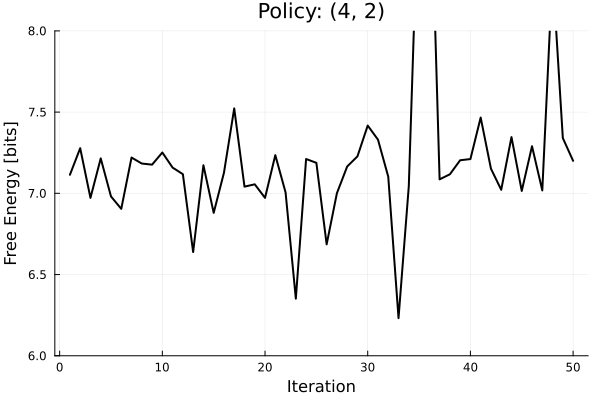

In [176]:
plot(1:n_its, G, color=:black, linewidth=2, xlabel="Iteration", ylabel="Free Energy [bits]", label=false, title="Policy: $pol", ylim=(6,8))